# Local_Outlier_Factor - Unsupervised

Local Outlier Factor - measures local variation of density of a samplet vs. its neighbors, where locality is determined by k-nearest neighbors. Lower density samples are considered outliers.

The strength of the LOF algorithm is that it takes both local and global properties of datasets into consideration: it can perform well even in datasets where abnormal samples have different underlying densities. The question is not, how isolated the sample is, but how isolated it is with respect to the surrounding neighborhood.

![Local Outlier Factor](datasets/sphx_glr_plot_lof_outlier_detection_001.png)

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

%matplotlib inline

In [2]:
train_split = 0.80
nrows = 1_000_000
path = 'c:/users/ugy1/abs/'
df=pd.read_csv(path+'datasets/processed_abs_loan_'+str(nrows)+'.csv', 
               #usecols=use_list, 
               #sep='\t',
               #compression=bz2,
               nrows=nrows,
               low_memory=False, 
              index_col=0, 
               parse_dates=True
              )
df.shape

(913751, 85)

In [3]:
column_list=df.columns.tolist()

In [4]:
df.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalance_[],"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,label
0,11940.46,60,0.2149,1,573.0,0.169781,6160.80,1225.49,0.2149,0.2149,...,1,0,0,0.0107,1.10,3.44,0.68,1.22,0.91,1.0
1,17501.22,62,0.0190,2,814.0,0.061246,4925.58,0.00,0.0190,0.0190,...,1,0,0,0.0100,1.00,3.31,0.75,0.57,0.94,0.0
2,13310.93,72,0.1897,2,578.0,0.050482,13310.93,463.85,0.1729,0.1729,...,1,0,0,0.0107,1.10,3.44,0.68,1.22,0.91,0.0
3,21427.33,72,0.0651,1,581.0,0.041312,20936.74,793.31,0.0651,0.0651,...,1,0,0,0.0107,1.10,3.44,0.68,1.22,0.91,0.0
4,6200.00,60,0.1868,1,614.0,0.092229,6200.00,239.06,0.1868,0.1868,...,1,0,0,0.0105,1.05,3.22,0.74,0.51,0.94,0.0


In [5]:
df.isnull().sum().any()

False

In [6]:
df.label.replace(1, -1, inplace=True)
df.label.replace(0, 1, inplace=True)

In [7]:
# prepare label for scikit-learn
Y=df.label.values
Y.shape

(913751,)

In [8]:
# prepare input data for scikit-learn
input=df.values
input.shape

(913751, 85)

In [9]:
# calculate train/test split

len_train = int(len(input)*train_split)
print(len_train)

731000


In [10]:
# apply train/test split to labels
y_train = Y[0:len_train]
y_test = Y[len_train:]
x_train = input[0:len_train]
x_test = input[len_train:]
x_train.shape

(731000, 85)

In [11]:
export_x_test = pd.DataFrame(data=x_test)

In [12]:
export_x_test.columns=column_list
export_x_test.rename(columns={'label':'True Label'}, inplace=True)
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,zerobalance_[],"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label
0,15634.45,72.0,0.1823,1.0,605.0,0.073820,15634.45,540.94,0.1823,0.1823,...,1.0,0.0,0.0,0.0107,1.10,3.44,0.68,1.22,0.91,1.0
1,21551.70,60.0,0.1980,2.0,624.0,0.129555,20658.05,858.09,0.1968,0.1968,...,1.0,0.0,0.0,0.0107,1.10,3.44,0.68,1.22,0.91,1.0
2,66580.36,60.0,1.9000,1.0,779.0,3.710000,49478.29,0.00,1.9187,1.9187,...,0.0,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,1.0
3,32845.00,72.0,12.5000,2.0,633.0,8.430000,32011.02,0.00,12.5000,12.5000,...,1.0,0.0,0.0,0.0090,1.00,3.31,0.75,0.57,0.94,1.0
4,58840.50,72.0,1.0000,0.0,842.0,6.400000,47673.87,0.00,1.0052,1.0052,...,0.0,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,1.0


In [13]:
#from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import RobustScaler
# from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import QuantileTransformer
# from sklearn.preprocessing import PowerTransformer

In [14]:
x_scaler=StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.fit_transform(x_test)

In [15]:
clf_LOF = LocalOutlierFactor(n_neighbors=20, metric='euclidean', algorithm='auto', contamination=0.15, n_jobs=-1)
#clf_LOF = LocalOutlierFactor(n_neighbors=20)

In [16]:
clf_LOF.fit(x_test)

LocalOutlierFactor(algorithm='auto', contamination=0.15, leaf_size=30,
          metric='euclidean', metric_params=None, n_jobs=-1,
          n_neighbors=20, p=2)

In [17]:
#_scores=clf_LOF.negative_outlier_factor_

In [18]:
x_pred = x_test

In [19]:
prediction_LOF = clf_LOF.fit_predict(x_pred)

In [20]:
np.unique(prediction_LOF)

array([-1,  1])

In [21]:
export_x_test['Predicted Label']=prediction_LOF

In [22]:
export_x_test.head()

,originalloanamount,originalloanterm,originalinterestratepercentage,graceperiodnumber,obligorcreditscore,paymenttoincomepercentage,reportingperiodbeginningloanbalanceamount,nextreportingperiodpaymentamountdue,reportingperiodinterestratepercentage,nextinterestratepercentage,...,"zerobalance_[""99""]","zerobalance_[""1""]",S&P/Experian Auto Default Index,AutoIndex,BankCardIndex,FirstMortgageIndex,SecondMortgageIndex,CompositeIndex,True Label,Predicted Label
0,15634.45,72.0,0.1823,1.0,605.0,0.073820,15634.45,540.94,0.1823,0.1823,...,0.0,0.0,0.0107,1.10,3.44,0.68,1.22,0.91,1.0,1
1,21551.70,60.0,0.1980,2.0,624.0,0.129555,20658.05,858.09,0.1968,0.1968,...,0.0,0.0,0.0107,1.10,3.44,0.68,1.22,0.91,1.0,1
2,66580.36,60.0,1.9000,1.0,779.0,3.710000,49478.29,0.00,1.9187,1.9187,...,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,1.0,1
3,32845.00,72.0,12.5000,2.0,633.0,8.430000,32011.02,0.00,12.5000,12.5000,...,0.0,0.0,0.0090,1.00,3.31,0.75,0.57,0.94,1.0,1
4,58840.50,72.0,1.0000,0.0,842.0,6.400000,47673.87,0.00,1.0052,1.0052,...,1.0,0.0,0.0099,0.99,3.86,0.68,0.59,0.92,1.0,1


In [23]:
export_x_test.shape

(182751, 86)

In [24]:
export_x_test.to_csv(path+"prediction/LOF/predicated_LOF_abs_loans_"+str(nrows)+".csv", chunksize=10000)

In [25]:
def plot_confusion_matrix(cm, title, classes=['non-Current', 'Current'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [26]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

             precision    recall  f1-score   support

Non-Current       0.08      0.14      0.10     16184
    Current       0.91      0.85      0.88    166567

avg / total       0.84      0.79      0.81    182751

AUC:  49.3%


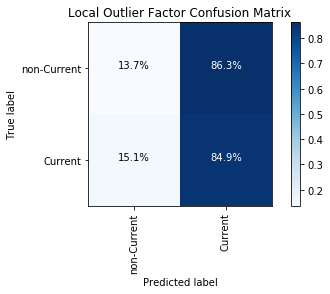

In [27]:
print(classification_report(y_test, prediction_LOF, target_names=['Non-Current', 'Current']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, prediction_LOF)))
cm = confusion_matrix(y_test, prediction_LOF)
plot_confusion_matrix(cm, title="Local Outlier Factor Confusion Matrix",save=True, 
                      saveas='prediction/LOF/cm'+str(' Local Outlier Factor Accuracy-')+str(nrows)+'.jpg')


ROC_AUC_SCORE ;  0.493063724265
Confusion matrix, without normalization
[[  2223  13961]
 [ 25190 141377]]


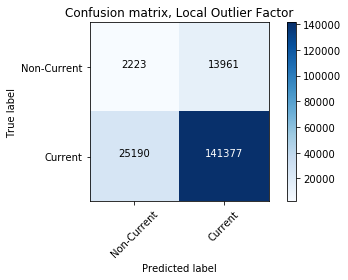

In [28]:
class_names = ['Non-Current', 'Current']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


print('ROC_AUC_SCORE ; ', roc_auc_score(y_test, prediction_LOF))
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, prediction_LOF)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title= 'Confusion matrix, Local Outlier Factor')
plt.savefig('prediction/LOF/cm'+str(' Local Outlier Factor Prediction-')+str(nrows)+'.jpg')
plt.show()